# Complex in droplet simulation

In [1]:
%pylab inline
import scipy.constants
import time
import popdrop

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [47]:
# Molar protein concentration
#c_molar = 2.5E-6 # [mol/l]
c_molar = 100E-6
#c_molar = 200E-6 # [mol/l]
# Protein mass
m_P = 53.3E3 # [Da]
# Simulation volume
V = 0.125E-18 # [m^3]
# Correction factor
ksi = 2.
# ksi = 30.
# Droplet radius (will be later rescaled to R_D_ksi)
R_D = 9.E-9

## Constants

In [48]:
# Protein mass density
rho_P = 0.84 / (1E-10)**3 # [Da/m^3]

## Derived parameters

In [49]:
# Hard sphere radius of protein
R_S = (m_P/rho_P * 3./4./pi)**(1/3.)
# Rescaled droplet radius
R_D_ksi = R_D * ksi
# SI protein concentration
c = c_molar * scipy.constants.Avogadro / 0.1**3 # [1/m^3]
# Number of particles in virutual box
N = int(round(V * c))
# Edge length of virtual box
L = V**(1/3.)

## Assign positions

In [5]:
def get_distance_sq(pos1, pos2):
    return ((pos1-pos2)**2).sum()

def get_distances_sq(positions, pos1):
    return ((positions-pos1)**2).sum(1)

def populate_box():
    r = array([rand(3)])
    d_sq_min = (R_S/L)**2
    for i in range(1,N):
        d_sq = 0
        while d_sq < d_sq_min:
            new = rand(3)
            d_sq = get_distances_sq(r,new).min()
        r = list(r)
        r.append(new)
        r = array(r)
    r *= L
    return r

def select_drop(r):
    x = ones(3) * L/2.
    pos = [r_close for r_close in r if get_distance_sq(r_close,x)<=R_D_ksi**2]
    return pos

def make_drop():
    seed()
    r = populate_box()
    pos = select_drop(r)
    print len(pos)
    return len(pos)



In [ ]:
import multiprocessing
jobs = []
for i in range(20):
    p = multiprocessing.Process(target=make_drop)
    jobs.append(p)
    p.start()
    time.sleep(0.01)
for j in jobs:
    j.join()

In [6]:
B = populate_box()

In [8]:
len(B)

7528

In [12]:
len(B) / L**3 * (0.1)**3 / scipy.constants.Avogadro / 1E-6

100.00429598024239

In [15]:
d_sq = get_distance_sq(array([0,1,1]),array([0,2,2]))
print sqrt(d_sq)

1.41421356237


In [27]:
select_drop(B)

[array([  2.51642003e-07,   2.51777770e-07,   2.52830663e-07])]

In [ ]:
n = zeros(50000)
for i in range(len(n)):
    n[i] = len(popdrop.popdrop(N, L, R_S, R_D_ksi))

In [5]:
from python_tools import multiprocesstools as mpt

In [50]:
import logging
logger = logging.getLogger("drop")
import h5py
Nprocesses = 16
Njobs = 8000
results = []
def worker(D):
    return {"pos" : popdrop.popdrop(N, L, R_S, R_D_ksi)}
def getwork():
    return {}
def logres(res):
    with h5py.File("drops.h5", "r+") as f:
        i = f["/i"][0]
        n_particles = len(res["pos"])
        f["/n_particles"][i] = n_particles
        if n_particles > 0:
            n = min([n_particles,f["/pos"].shape[1]])
            f["/pos"][i,:n,:] = res["pos"][:,:]
        f["/i"][0] = i + 1
def loginit(N_max=10):
    with h5py.File("drops.h5", "w") as f:
        f["/n_particles"] = numpy.zeros(shape=(Njobs))
        f["/pos"] = numpy.zeros(shape=(Njobs,N_max,3))
        f["/i"] = [0]
def getres():
    with h5py.File("drops.h5", "r") as f:
        pos = array(f["/pos"])
        n_particles = array(f["/n_particles"])
    return n_particles,pos

In [51]:
loginit(10)
mpt.multiprocess(Nprocesses,Njobs,worker,getwork,logres=logres,logger=logger)

In [52]:
n_particles,res = getres()
n_particles.sum()

11886.0

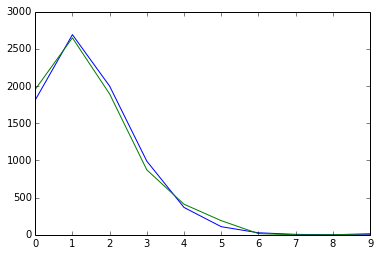

In [75]:
from scipy.misc import factorial
H = histogram(n_particles, bins=10, range=(0,10))
hist_n = H[0]
hist_bins = H[1]
hist_bins = hist_bins[:-1] #+ (hist_bins[1]-hist_bins[0])/2.
l = n_particles.mean()
poisson_model = lambda k,l: (l**k*exp(-l))/factorial(k)
hist_n_poisson = array([poisson_model(n, n_particles.mean()) for n in hist_bins])
plot(hist_bins, hist_n_poisson*hist_n.sum()/hist_n_poisson.sum())
plot(hist_bins, hist_n)